In [1]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import sys
import os

/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 读取数据

In [2]:
os.chdir('/home/liwb/Documents/projects/angelAndDemon/')
version='4'
trainPath = './dataAfterProcess/trainRes%s.csv'%(version)
trainData = pd.read_csv(trainPath, header=None)
X = trainData.values[:,0:trainData.shape[1]-1]
y = trainData.values[:,trainData.shape[1]-1]

testPath = './dataAfterProcess/testRes%s.csv'%(version)
testData = pd.read_csv(testPath, header=None)
testX = testData.values
print(X.shape, y.shape, testX.shape)

(112405, 875) (112405,) (28101, 875)


In [2]:
#淼鑫的数据
import pickle
f = open('./dataAfterProcess/train_set.js','rb')
train_set = pickle.load(f)
f.close()

train_set = np.array(train_set)

f = open('./dataAfterProcess/valid_set.js','rb')
valid_set = pickle.load(f)
f.close()

valid_set = np.array(valid_set)

train_mx = np.vstack((train_set, valid_set))
print(train_mx.shape)
print(sum(train_mx[:,train_mx.shape[1]-1]))

X_mx = train_mx[:,0:train_mx.shape[1]-1]
y_mx = train_mx[:,train_mx.shape[1]-1]




f = open('./dataAfterProcess/test_set.js','rb')
test_set = pickle.load(f)
f.close()
testX_mx = np.array(test_set)
print(testX_mx.shape)

(112405, 1137)
330.0
(28101, 1136)


### xgboost 的交叉验证，一般xgb的交叉验证是用来观测那些参数的效果好。然后再用好的参数去train。

In [3]:
#对xgboost模型进行交叉验证，并且画出ROC曲线。
def xgboost_cv(X, y, xgboost, Kfold):
    random_state = np.random.RandomState(0)
    skf = StratifiedKFold(n_splits=Kfold,random_state=random_state) #k fold交叉验证
    i=0
    xgb_models = []
    for train_index, test_index in skf.split(X,y):
        xgb_model = xgboost
        xgb_model = xgb_model.fit(X[train_index], y[train_index], 
                                  eval_set=[(X[train_index], y[train_index]),
                                            (X[test_index], y[test_index])],
                                  eval_metric = "auc",
                                  verbose = False)

        #evals_result = xgb_model.evals_result()
        #print(evals_result)
        probas_ = xgb_model.predict_proba(X[test_index])

        #[:,1]二分类有0的概率，也有预测为1的概率，这里提取预测为1的概率
        fpr, tpr, thresholds = roc_curve(y[test_index], probas_[:,1])
        roc_auc = auc(fpr, tpr)
        score = roc_auc_score(y[test_index] , probas_[:,1])#验证集的auc分数

        train_probas = xgb_model.predict_proba(X[train_index])
        train_score = roc_auc_score(y[train_index], train_probas[:,1])#训练集的auc分数
        print("auc_test: %5f,auc_train:%5f in %d fold. index shape:%d"\
              %(score, train_score, i, len(train_index))) 

        plt.plot(fpr, tpr, lw=1, alpha=0.8,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        xgb_models.append(xgb_model)
    

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    plt.show()
    return xgb_models

auc_test: 0.897116,auc_train:1.000000 in 0 fold. index shape:89924
auc_test: 0.916728,auc_train:1.000000 in 1 fold. index shape:89924
auc_test: 0.902492,auc_train:1.000000 in 2 fold. index shape:89924
auc_test: 0.900794,auc_train:1.000000 in 3 fold. index shape:89924
auc_test: 0.884229,auc_train:1.000000 in 4 fold. index shape:89924


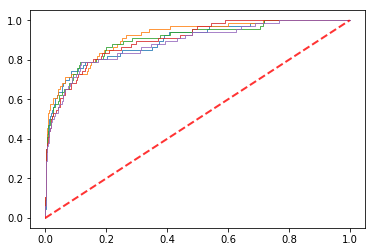

In [4]:
xgb_model_cv = xgb.XGBClassifier(booster='gbtree',
                              silent=True,
                              #n_jobs=5, #不设置的话，自动获得最大线程数
                              #以上为general params
                              
                              learning_rate = 0.1,#在xgboost的package中等价于eta参数
                              min_child_weight = 2, #控制过拟合，越大越不会过拟合
                              
                              max_depth=100, #控制过拟合，越小越不会过拟合
                              max_delta_step = 1, #数据不均衡的时候可以用
                              gamma = 0,         #模型在默认情况下，对于一个节点的划分
                                                 #只有在其loss function 得到结果大于0的情况下才进行，
                                                 #而gamma 给定了所需的最低loss function的值.
                                                 #所以gamma越大越保守（conservation）
                              subsample = 0.8,    #太大会过拟合，太小会欠拟合
                              colsample_bytree=0.8, #
                              reg_lambda = 100, #L2正则化的权重参数,给linear模型用的。gbtree不用
                              reg_alpha = 0, #L1正则化的权重参数,给linear模型用的。gbtree不用
                              scale_pos_weight=340,
                              #以上是booster的参数
                              
                              
                              random_state = 0,
                              n_estimators = 200)#树的棵树


xgbModels = xgboost_cv(X, y, xgb_model_cv, 5)

### 对交叉验证得到的模型，将它们用于测试集，并将平均得到的结果保存

In [7]:
from sklearn.externals import joblib #jbolib模块
#将xgboost交叉验证的几个模型去预测测试集，并且对其取平均
def testModel(models, testX, versionSaved='100'):
    i=0
    probas = []
    for xgb_final in models:
        predict = xgb_final.predict(testX)
        #查看有多少样本被预测为1
        print('samples have been predicted as positive samples: ', \
              sum(predict),'in %d model'%(i))
        probas_ = xgb_final.predict_proba(testX)
        probas.append(probas_[:,1])
        i+=1

    print(type(probas))
    print(len(probas), len(probas[0]))
    predict = np.sum(probas, axis=0)/len(probas)
    #保存测试集的预测结果
    result = pd.read_csv('./originalDataset/exampleSubmission.csv')
    result.label = predict
    result.to_csv('./outputs/submission%s.csv'%(versionSaved), index=False)
    
    #joblib.dump(xgb_final, './models/xgbModel_%s.model'%(versionSaved))

In [11]:
testModel([clf2], testX, '875ensemble')

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874']
training data did not have the following fields: f599, f396, f474, f788, f383, f203, f744, f357, f251, f208, f739, f830, f604, f404, f457, f537, f650, f790, f513, f220, f377, f676, f848, f268, f493, f371, f318, f441, f381, f480, f244, f527, f284, f279, f385, f704, f168, f431, f321, f714, f173, f442, f627, f271, f545, f308, f610, f314, f196, f820, f815, f557, f706, f467, f446, f312, f850, f752, f153, f656, f436, f747, f172, f164, f833, f776, f634, f520, f405, f390, f645, f753, f563, f490, f485, f288, f609, f771, f798, f618, f647, f866, f695, f238, f456, f813, f817, f740, f195, f703, f745, f249, f177, f255, f302, f725, f199, f240, f510, f666, f234, f236, f591, f187, f795, f834, f503, f421, f843, f709, f150, f333, f317, f352, f746, f202, f533, f707, f328, f737, f486, f829, f816, f261, f281, f235, f764, f398, f407, f657, f605, f188, f861, f554, f601, f653, f304, f570, f497, f433, f269, f325, f568, f665, f430, f579, f587, f690, f607, f451, f411, f237, f169, f276, f499, f285, f330, f362, f369, f760, f823, f826, f160, f724, f654, f534, f459, f414, f683, f438, f287, f874, f697, f730, f784, f519, f869, f468, f491, f589, f386, f827, f322, f667, f374, f792, f722, f822, f418, f152, f399, f477, f345, f621, f323, f832, f853, f254, f370, f623, f791, f415, f870, f245, f257, f409, f482, f720, f594, f576, f300, f726, f797, f207, f313, f800, f439, f223, f831, f299, f810, f498, f765, f651, f239, f721, f403, f511, f259, f643, f523, f644, f819, f229, f807, f337, f713, f410, f593, f748, f293, f639, f521, f394, f228, f339, f171, f267, f243, f872, f422, f380, f757, f551, f783, f219, f546, f566, f673, f649, f775, f423, f620, f659, f759, f327, f526, f715, f332, f640, f280, f613, f808, f868, f571, f572, f575, f638, f462, f774, f361, f671, f799, f578, f402, f710, f505, f793, f818, f258, f213, f373, f201, f558, f590, f161, f200, f574, f606, f506, f334, f387, f227, f464, f450, f193, f628, f509, f163, f741, f824, f567, f846, f750, f608, f233, f805, f693, f427, f461, f857, f742, f751, f248, f532, f286, f368, f560, f700, f413, f777, f524, f489, f272, f858, f155, f166, f273, f283, f343, f738, f230, f347, f763, f863, f842, f384, f541, f192, f274, f452, f206, f372, f531, f655, f680, f762, f767, f641, f768, f167, f719, f844, f226, f158, f264, f290, f684, f779, f211, f787, f512, f495, f253, f295, f186, f809, f151, f191, f307, f625, f670, f556, f522, f338, f851, f736, f756, f803, f550, f342, f247, f326, f565, f408, f836, f766, f547, f549, f615, f504, f663, f354, f838, f429, f440, f426, f837, f660, f603, f632, f205, f664, f755, f246, f222, f681, f781, f581, f159, f555, f539, f543, f364, f501, f367, f225, f692, f315, f218, f661, f802, f642, f770, f617, f419, f463, f542, f569, f185, f319, f382, f483, f500, f624, f270, f252, f379, f806, f841, f701, f465, f801, f691, f782, f631, f622, f772, f585, f432, f518, f190, f366, f311, f672, f675, f375, f359, f282, f530, f198, f708, f278, f735, f514, f794, f400, f397, f355, f174, f696, f864, f743, f811, f702, f178, f303, f552, f391, f320, f215, f840, f305, f785, f658, f536, f346, f351, f758, f242, f445, f435, f561, f182, f296, f749, f289, f559, f475, f487, f291, f825, f224, f453, f183, f619, f417, f476, f716, f614, f867, f294, f471, f157, f630, f204, f611, f508, f306, f689, f194, f873, f595, f712, f582, f688, f629, f773, f156, f292, f335, f458, f447, f162, f231, f454, f525, f698, f845, f348, f682, f184, f181, f341, f434, f584, f731, f528, f401, f470, f646, f648, f210, f780, f544, f209, f839, f732, f694, f849, f761, f812, f679, f507, f389, f496, f277, f221, f449, f535, f728, f492, f852, f425, f669, f592, f358, f256, f360, f515, f598, f678, f562, f633, f860, f455, f420, f232, f406, f705, f821, f538, f265, f600, f553, f734, f612, f460, f262, f329, f733, f154, f472, f149, f855, f859, f298, f686, f473, f588, f395, f336, f856, f484, f786, f469, f769, f393, f835, f729, f363, f871, f392, f344, f214, f443, f378, f616, f189, f517, f636, f175, f217, f176, f814, f212, f586, f583, f828, f577, f494, f297, f718, f685, f865, f573, f754, f540, f626, f331, f388, f727, f548, f580, f711, f789, f180, f674, f637, f428, f448, f412, f263, f416, f778, f862, f350, f275, f516, f301, f310, f424, f488, f596, f804, f602, f179, f266, f309, f353, f662, f349, f479, f170, f365, f597, f717, f652, f677, f529, f340, f250, f502, f376, f444, f197, f356, f847, f796, f241, f466, f216, f564, f165, f854, f687, f668, f260, f316, f699, f481, f478, f324, f635, f723, f437


### 训练模型，并且使用测试集预测。将结果保存

In [3]:
from sklearn.externals import joblib #jbolib模块

#训练模型，并且用测试集测试，得到预测结果，保存预测结果
def xgboostTrain(X, y, testX, xgb_final, versionSaved='100', params=None):
    xgb_final = xgb_final.fit(X, y, 
                     eval_set=[(X, y)],
                     eval_metric = "auc",
                     verbose = False)
    
    print(xgb_final.evals_result())
    predict = xgb_final.predict(testX)
    #查看有多少样本被预测为1
    print(sum(predict),' samples have been predicted as positive samples')
    probas_ = xgb_final.predict_proba(testX)
    probas = probas_[:,1]
    
    #保存测试集的预测结果
    result = pd.read_csv('./originalDataset/exampleSubmission.csv')
    result.label = probas
    result.to_csv('./outputs/submission%s.csv'%(versionSaved), index=False)
    
    #保存模型
    joblib.dump(xgb_final, './models/xgbModel_%s.model'%(versionSaved))
    #clf2 = joblib.load('./models/xgb_0501test2.model')


In [4]:
xgb_final = xgb.XGBClassifier(booster='gbtree',
                              silent=True,
                              #n_jobs=5, #不设置的话，自动获得最大线程数
                              #以上为general params
                              
                              learning_rate = 0.1,#在xgboost的package中等价于eta参数
                              min_child_weight = 2, #控制过拟合，越大越不会过拟合
                              
                              max_depth=100, #控制过拟合，越小越不会过拟合
                              max_delta_step = 1, #数据不均衡的时候可以用
                              gamma = 0,         #模型在默认情况下，对于一个节点的划分
                                                 #只有在其loss function 得到结果大于0的情况下才进行，
                                                 #而gamma 给定了所需的最低loss function的值.
                                                 #所以gamma越大越保守（conservation）
                              subsample = 0.8,    #太大会过拟合，太小会欠拟合
                              colsample_bytree=0.8, #
                              reg_lambda = 100, #L2正则化的权重参数,给linear模型用的。gbtree不用
                              reg_alpha = 0, #L1正则化的权重参数,给linear模型用的。gbtree不用
                              scale_pos_weight=340,
                              #以上是booster的参数
                              
                              
                              random_state = 0,
                              n_estimators = 200)#树的棵树

#xgboostTrain(X, y, testX, xgb_final, versionSaved= '200depth')
xgboostTrain(X_mx, y_mx, testX_mx, xgb_final, versionSaved= '0501_mx')

{'validation_0': {'auc': [0.930371, 0.98661, 0.992024, 0.994209, 0.996645, 0.996554, 0.997383, 0.998314, 0.998789, 0.999085, 0.999282, 0.999357, 0.99947, 0.999582, 0.999644, 0.999699, 0.999742, 0.999765, 0.999774, 0.999782, 0.999783, 0.999802, 0.999808, 0.999819, 0.99982, 0.999826, 0.99984, 0.999848, 0.999861, 0.999862, 0.999866, 0.999872, 0.999878, 0.999891, 0.999893, 0.999893, 0.999905, 0.99991, 0.999913, 0.999917, 0.999922, 0.999926, 0.999931, 0.999937, 0.999941, 0.999942, 0.999946, 0.999949, 0.999952, 0.999955, 0.999959, 0.999965, 0.999967, 0.99997, 0.999973, 0.999975, 0.999978, 0.99998, 0.99998, 0.999982, 0.999983, 0.999983, 0.999986, 0.999986, 0.999988, 0.999988, 0.99999, 0.999991, 0.999992, 0.999993, 0.999993, 0.999993, 0.999994, 0.999993, 0.999993, 0.999994, 0.999994, 0.999994, 0.999995, 0.999995, 0.999995, 0.999995, 0.999995, 0.999996, 0.999996, 0.999997, 0.999997, 0.999997, 0.999997, 0.999997, 0.999997, 0.999997, 0.999997, 0.999998, 0.999998, 0.999998, 0.999998, 0.999998, 0.9

FileNotFoundError: File b'./originalDataset/exampleSubmission.csv' does not exist

### 用gridsearch进行调参

In [25]:
print(X.shape, y.shape)

(112405, 1136) (112405,)


In [57]:
param_test1 = {
    #'n_estimators':[i for i in range(30,50,2)],
    #'max_depth':[i for i in range(3,10)],
    #'min_child_weight':[i for i in range(1,6)],
    #'gamma':[i/10.0 for i in range(5)],
    #'subsample':[i/10.0 for i in range(5,10)],
    #'colsample_bytree':[i/10.0 for i in range(5,10)],
    #'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100],
    #'max_delta_step':[i for i in range(1,10)],
    'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
}
xgb_model = xgb.XGBClassifier(booster='gbtree',
                              silent=True,
                              #n_jobs=5, #不设置的话，自动获得最大线程数
                              #以上为general params
                              
                              learning_rate = 0.1,#在xgboost的package中等价于eta参数
                              min_child_weight = 2, #控制过拟合，越大越不会过拟合
                              
                              max_depth=9, #控制过拟合，越小越不会过拟合
                              max_delta_step = 1, #数据不均衡的时候可以用
                              gamma = 0,         #模型在默认情况下，对于一个节点的划分
                                                 #只有在其loss function 得到结果大于0的情况下才进行，
                                                 #而gamma 给定了所需的最低loss function的值.
                                                 #所以gamma越大越保守（conservation）
                              subsample = 0.8,    #太大会过拟合，太小会欠拟合
                              colsample_bytree=0.8, #
                              reg_lambda = 100, #L2正则化的权重参数,给linear模型用的。gbtree不用
                              reg_alpha = 0, #L1正则化的权重参数,给linear模型用的。gbtree不用
                              scale_pos_weight=340,
                              #以上是booster的参数
                              
                              
                              random_state = 0,
                              n_estimators = 48)#树的棵树

gsearch1 = GridSearchCV(estimator=xgb_model, 
                        param_grid = param_test1, 
                        scoring = "roc_auc",
                        n_jobs = 4,
                        iid = False, 
                        cv = 5)


gsearch1.fit(X, y)
print(gsearch1.best_params_)
#print(gsearch1.best_estimator_)
print(gsearch1.best_score_)

{'learning_rate': 0.1}
0.8847955576284819


In [52]:
#print(gsearch1.cv_results_)
print(gsearch1.best_params_)
#print(gsearch1.best_estimator_)
print(gsearch1.best_score_)

{'min_child_weight': 2, 'max_depth': 9}
0.8760356633477311


### stacking model

In [64]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

import seaborn as sns

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import sys
import os

In [65]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)
        


In [72]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'class_weight':{0:1,1:340},
    'random_state':0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state':0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state':0
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'subsample':0.8,
    'verbose': 0,
    'random_state':0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }



# Create 5 objects that represent our 4 models
SEED = 0
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [70]:
def get_oof(clf, X, y, testX, Kfold):
    skf = StratifiedKFold(n_splits=Kfold,random_state=random_state) #k fold交叉验证
    
    oof_test_skf = np.empty((Kfold, testX.shape[0]))
    oof_train = np.zeros((X.shape[0],))
    oof_test = np.zeros((testX.shape[0],))
    i=0
    for train_index, test_index in skf.split(X, y):
        clf.train(X[train_index], y[train_index])
        oof_train[test_index] = clf.predict(X[test_index])
        
        oof_test_skf[i,:] = clf.predict(testX)
        i += 1
    
    oof_test[:] = oof_test_skf.mean(axis=0)#测试集需要求均值
    
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [73]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X, y, testX,5) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X, y, testX,5) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X, y, testX,5) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X, y, testX,5) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,X, y, testX,5) # Support Vector Classifier

print("Training is complete")

/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [74]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [75]:
print(x_train.shape, x_test.shape)

(112405, 5) (28101, 5)


In [76]:
xgb_model = xgb.XGBClassifier(booster='gbtree',
                              silent=True,
                              #n_jobs=5, #不设置的话，自动获得最大线程数
                              #以上为general params
                              
                              learning_rate = 0.1,#在xgboost的package中等价于eta参数
                              min_child_weight = 2, #控制过拟合，越大越不会过拟合
                              
                              max_depth=5, #控制过拟合，越小越不会过拟合
                              max_delta_step = 1, #数据不均衡的时候可以用
                              gamma = 0.9,         #模型在默认情况下，对于一个节点的划分
                                                 #只有在其loss function 得到结果大于0的情况下才进行，
                                                 #而gamma 给定了所需的最低loss function的值.
                                                 #所以gamma越大越保守（conservation）
                              subsample = 0.8,    #太大会过拟合，太小会欠拟合
                              colsample_bytree=0.8, #
                              reg_lambda = 100, #L2正则化的权重参数,给linear模型用的。gbtree不用
                              reg_alpha = 0, #L1正则化的权重参数,给linear模型用的。gbtree不用
                              scale_pos_weight=340,
                              #以上是booster的参数
                             
                              
                              random_state = 0,
                              n_estimators = 480)#树的棵树

xgb_model.fit(x_train, y)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.9, learning_rate=0.1,
       max_delta_step=1, max_depth=5, min_child_weight=2, missing=None,
       n_estimators=480, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=100, scale_pos_weight=340, seed=None, silent=True,
       subsample=0.8)